In [ ]:
 # To mount Google Drive
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/ocsvm_results.csv')
print("Original Size of dataset: {}".format(len(df)))

profiles_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_profiles.csv')
print("Original number of users: {}".format(len(profiles_df)))


filtered_df = df[df['fake_reviews'] == 1]
suspicious_users = list(set(filtered_df['acc_num']))
print("Number of suspicious users: {}".format(len(suspicious_users)))

filtered_df = df[df['acc_num'].isin(suspicious_users)]
print("Size of dataset with fake reviews: {}".format(len(filtered_df)))

Original Size of dataset: 77268
Original number of users: 65930
Number of suspicious users: 56367
Size of dataset with fake reviews: 66939


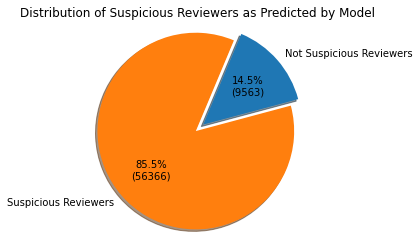

In [ ]:
import matplotlib.pyplot as plt

# # Creating plot 
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

non_suspicious_users = len(profiles_df) -  len(suspicious_users)

my_explode = (0, 0.1)
plt.pie([non_suspicious_users, len(suspicious_users)],labels=['Not Suspicious Reviewers','Suspicious Reviewers'],autopct=lambda pct: func(pct, [non_suspicious_users, len(suspicious_users)]),startangle=15, shadow = True, explode=my_explode)
plt.title("Distribution of Suspicious Reviewers as Predicted by Model")
plt.axis('equal')
plt.show()

In [ ]:
import networkx as nx

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

try:
    network_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv')
except:
    !pip install --upgrade rgmining-fraud-eagle

    import fraud_eagle as feagle

    # Create a graph with a parameter `epsilon`.
    epsilon = 0.1
    graph = feagle.ReviewGraph(epsilon)

    reviewers = {}
    for reviewer in set(filtered_df['acc_num']):
        reviewers[reviewer] = graph.new_reviewer(reviewer)

    products = {}
    for product in set(filtered_df['asin']):
        products[product] = graph.new_product(product)

    for reviewer, product, rating in zip(filtered_df['acc_num'], filtered_df['asin'],filtered_df['cleaned_reviews_ratings']):
        graph.add_review(reviewers[reviewer], products[product], rating)

    max_iteration = 10000
    for i in range(max_iteration):

        # Run one iteration.
        diff = graph.update()
        print("Iteration {}...Difference={}".format(i + 1, diff))

        if diff < 10**-5: # Set 10^-5 as an acceptable small number.
            print("Difference is significantly small...Stopping Iteration...")
            break
    top_users = [r.name for r in graph.reviewers if r.anomalous_score >= 0.9]
    print(top_users)
    print(len(top_users))

    build_network = {"user1":[],"user2":[],"weights":[]}
    for i,user1 in enumerate(top_users):
        products_for_user1 = list(new_filtered_df[new_filtered_df['acc_num'] == user1]['asin'])
        for user2 in top_users[1:]:
            if user1 != user2:
                products_for_user2 = list(new_filtered_df[new_filtered_df['acc_num'] == user2]['asin'])
                overlap_products = list(set(products_for_user1) & set(products_for_user2))
                if len(overlap_products) >= 2:
                    build_network['user1'].append(user1)
                    build_network['user2'].append(user2)
                    build_network['weights'].append(len(overlap_products))
        print("Current Iteration: {}/{}".format(i+1,len(top_users)))
        print("Current Dataset size: {}...\n".format(len(build_network['user1'])))

    network_df = pd.DataFrame.from_dict(build_network)
    user1_names = []
    user2_names = []
    for index, row in network_df.iterrows():
        user1_name = str(list(profiles_df.loc[profiles_df['acc_num'] == row['user1'],'name'])[0])
        user2_name = str(list(profiles_df.loc[profiles_df['acc_num'] == row['user2'],'name'])[0])
        user1_names.append(user1_name)
        user2_names.append(user2_name)

    deleted_users = ['Amazon user', 'Amazon Customer']
    network_df['user1_name'] = user1_names
    network_df['user2_name'] = user2_names
    network_df = network_df[(~network_df['user1_name'].isin(deleted_users)) & (~network_df['user2_name'].isin(deleted_users))]
    print("New Length of Network Dataset after keeping interested nodes: {}".format(len(network_df)))
    display(network_df)

    interested_graph = build_graph(network_df)
    network_df.to_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv',index=False)
print("Original Length of Network Dataset: {}".format(len(network_df)))

print("New Length of Network Dataset after filtering number of overlap history >= 2: {}".format(len(network_df)))
display(network_df)


Original Length of Network Dataset: 91704
New Length of Network Dataset after filtering number of overlap history >= 2: 91704


user1  ...      user2_name
0      AFBP6VGFOPIUGJP6MTEAKTIOFG6Q  ...  Charles L Odom
1      AFBP6VGFOPIUGJP6MTEAKTIOFG6Q  ...     Beth Beach 
2      AFBP6VGFOPIUGJP6MTEAKTIOFG6Q  ...  Cristina Reyes
3      AFBP6VGFOPIUGJP6MTEAKTIOFG6Q  ...   dana m hardee
4      AFBP6VGFOPIUGJP6MTEAKTIOFG6Q  ...          Liddie
...                             ...  ...             ...
91699  AGDM5KOGS4NOGTO3RFECBHKZKXXQ  ...     Daniel Bets
91700  AGDM5KOGS4NOGTO3RFECBHKZKXXQ  ...         Natalia
91701  AGDM5KOGS4NOGTO3RFECBHKZKXXQ  ...           pamcs
91702  AGDM5KOGS4NOGTO3RFECBHKZKXXQ  ...        Tyian S.
91703  AH3Z3NLTXUC4JNBC7N2SSOMZS7FQ  ...            madi

[91704 rows x 5 columns]

In [ ]:
import plotly.graph_objects as go
from networkx.algorithms.centrality import *
import networkx as nx
import pandas as pd

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

def visualize_graph(graph,network_df):
    pos = nx.spring_layout(graph,k=4, iterations=500)

    edge_x = []
    edge_y = []
    for edge in graph.edges():
        from_edge = edge[0]
        to_edge = edge[1]
        x0 = pos[from_edge][0]
        y0 = pos[from_edge][1]
        x1 = pos[to_edge][0]
        y1 = pos[to_edge][1]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    node_x = []
    node_y = []
    node_text = []
    for node in graph.nodes():
        x = pos[node][0]
        y = pos[node][1]
        node_x.append(x)
        node_y.append(y)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='Jet',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Betweeness Centrality',
                xanchor='left',
                titleside='right'
            ),
        line_width=2))

    reviewers_name = list(network_df['user1_name']) + list(network_df['user1_name'])
    reviewers_acc_name =  list(network_df['user1']) + list(network_df['user2'])
    reviewer_mapping = {}

    for reviewer_acc_name, reviewer_name in zip(reviewers_acc_name,reviewers_name):
        if reviewer_acc_name not in reviewer_mapping:
            reviewer_mapping[reviewer_acc_name] = reviewer_name
    node_adjacencies = []
    betweeness = betweenness_centrality(interested_graph)
    color = []
    node_text = []
    for node, adjacencies in enumerate(graph.adjacency()):
        temp_graph = graph.to_undirected()
        neighbours = list(temp_graph.neighbors(adjacencies[0]))
        neighbours = [neighbour for neighbour in neighbours if neighbour != adjacencies[0]]
        number_neighbours = len(neighbours)
        node_adjacencies.append(number_neighbours)
        color.append(betweeness[adjacencies[0]])
        node_text.append("{} has {} connections. Reviewer's Account Number is {}".format(reviewer_mapping[adjacencies[0]],number_neighbours,adjacencies[0]))

    node_trace.marker.color = color
    max_adjacencies = max(node_adjacencies)
    node_adjacencies = [max(10,20*(node_adjacency/max_adjacencies)) for node_adjacency in node_adjacencies]
    node_trace.marker.size = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                # margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                title="Network Containing Top Suspicious Reviewers" 
                )
                )
    
    fig.update_layout(yaxis = dict(scaleanchor = "x", scaleratio = 1), plot_bgcolor='rgb(255,255,255)')
    
    return fig

interested_graph = build_graph(network_df)
fig = visualize_graph(interested_graph,network_df)
fig.show()

In [ ]:
suspicious_reviewers_betweeness = betweenness_centrality(interested_graph)
suspicious_reviewers_betweeness = {key: value for (key, value) in sorted(suspicious_reviewers_betweeness.items(), key=lambda item: item[1],reverse=True) if value > 0}

print(suspicious_reviewers_betweeness)
print("Number of Suspicious Reviewers with more than 0 betweeness centrality: {}".format(len(suspicious_reviewers_betweeness)))

{'AHT7S3FVSF7JLMSUR4UER6QWCKRQ': 0.09272176515009567, 'AENFQCM7CLHY2BJPSGK2G55WX7MQ': 0.07476630649761562, 'AFSCN7KTUEMGKDNWDS2LUKDMBJJQ': 0.07476630649761562, 'AE4M4BVD6UX4AM4AI5SX5HGEBHNA': 0.07476630649761562, 'AGOTPXCSSDNXWBO2HHD2QWN4JYWQ': 0.06074800847144861, 'AHMG3ALUBE3FEBHODTBHP5J24YDA': 0.013343099346472032, 'AEJ4JEMOVWOME73YXCU2HY5IP2SQ': 0.010697191135639708, 'AFEKWSH62Z4SU774EIMZPLB5CZMA': 0.002691331527756485, 'AESR7TTDJZLFFLHMZ7562QRYYYIQ': 0.00031228530385360063, 'AEVH67Q5PC4DQSWLHEUXRJ4QL7FQ': 0.0002895736453915206, 'AHDQBHQRTO2V3WA3XH2HXXABD3EQ': 0.00022711658462080047, 'AHVTVSH5YF6TFE4NRSE6YB5HPHKQ': 7.949080461728017e-05, 'AFMVVRBFZIQSKDPXRX2BGH44HXHQ': 7.381289000176015e-05, 'AHXTMAM4DSFRJRWJVVS4CMYLL5JQ': 2.838957307760006e-05, 'AFMYDGF3WUNIPG5JPS44LOVGQZOQ': 1.1355829231040024e-05, 'AHDL66QTRBNQBUVAUOD44VUPE3SA': 5.677914615520012e-06}
Number of Suspicious Reviewers with more than 0 betweeness centrality: 16


In [ ]:
top3_suspicious_reviewers = list(suspicious_reviewers_betweeness.keys())[:3]

In [ ]:

interested_df = df[df['acc_num'].isin(top3_suspicious_reviewers)]
interested_columns = ['cleaned_reviews_date_posted','asin','acc_num','cleaned_reviews_verified','cleaned_reviews_ratings','cleaned_reviews_text']
current_df = interested_df[interested_columns]
current_df = current_df.sort_values(by=['asin','cleaned_reviews_date_posted'])
current_df.columns = ['Date Posted','Product ASIN','User','Verified Purchase','Rating','Text']
display(current_df)

Date Posted  ...                                               Text
72523  2017-08-08  ...                    like lot feels good take makeup
72525  2017-06-17  ...  ah sorry like one fault mine go store try firs...
72524  2017-06-17  ...  ah sorry like one fault mine go store try firs...
23649  2017-05-24  ...  fine face cream ever use keep face moisturize ...
38837  2017-06-17  ...  normally love anything loreal one hat face cou...
75     2019-12-21  ...  need kind spoon order get product jar instead ...
15007  2019-03-14  ...  use twice per day several week notice change w...
384    2019-12-21  ...                               nothing face wrinkle
16519  2017-05-24  ...  fine face cream ever use keep face moisturize ...
43273  2017-06-17  ...  normally love anything loreal one hat face cou...
445    2019-12-21  ...  need kind spoon order get product jar instead ...
13967  2019-03-14  ...  use twice per day several week notice change w...
1247   2019-12-21  ...                               nothing face wrinkle
26964  2019-03-14  ...  use twice per day several week notice change w...
933    2019-12-21  ...                               nothing face wrinkle

[15 rows x 6 columns]

In [ ]:
interested_network_users = network_df[(network_df['user1'].isin(top3_suspicious_reviewers)) | (network_df['user2'].isin(top3_suspicious_reviewers))]
unique_users = list(set(list(interested_network_users['user1']) + list(interested_network_users['user2'])))
unique_users = [user for user in unique_users if user not in top3_suspicious_reviewers]
interested_user_df = profiles_df[profiles_df['acc_num'].isin(unique_users)]
display(interested_user_df)

json_data  ... cleaned_badges
3244   {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
3246   {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
3253   {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
3258   {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
3271   {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
...                                                  ...  ...            ...
64819  {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
64830  {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
64832  {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
64834  {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0
64836  {'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...  ...              0

[467 rows x 40 columns]

<Figure size 720x504 with 0 Axes>

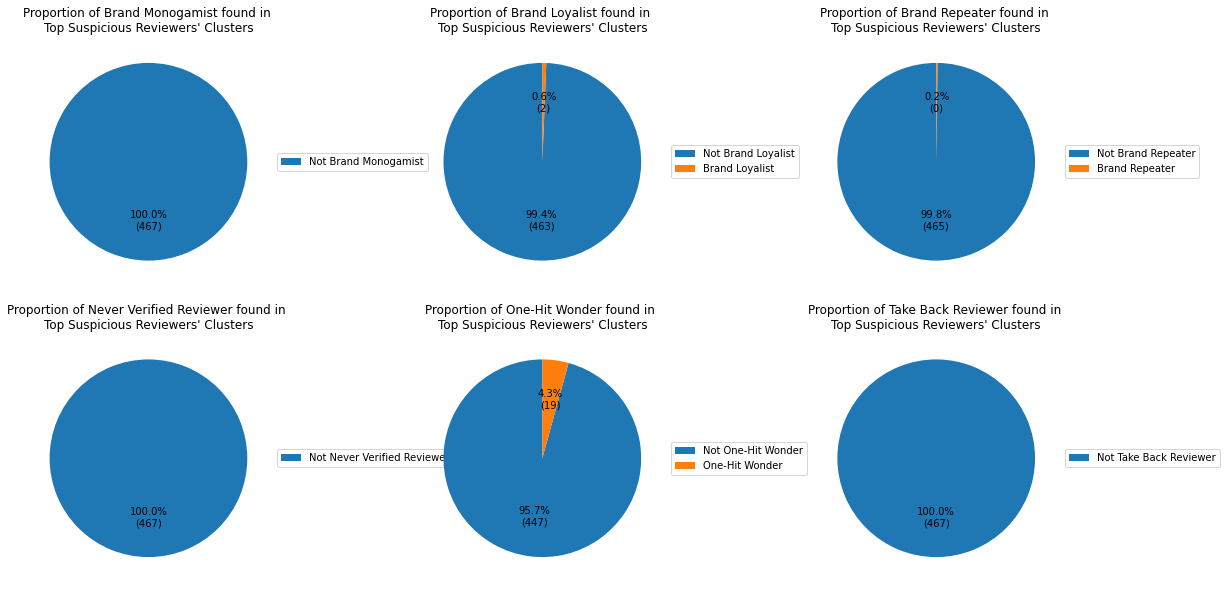

In [ ]:
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize =(10, 7)) 

plot_df = interested_user_df[['cleaned_brand_monogamist','cleaned_brand_loyalist','cleaned_brand_repeater','cleaned_never_verified_reviewer','cleaned_one_hit_wonder','cleaned_take_back_reviewer']]

sub_values = {'cleaned_brand_monogamist':'Brand Monogamist','cleaned_brand_loyalist':'Brand Loyalist','cleaned_brand_repeater':'Brand Repeater','cleaned_never_verified_reviewer':'Never Verified Reviewer','cleaned_one_hit_wonder':"One-Hit Wonder",'cleaned_take_back_reviewer':'Take Back Reviewer'}

fig, ax = plt.subplots(2,3, figsize=(20,10))

ax = ax.ravel()

for i, column in enumerate(plot_df):
    temp_df = plot_df.groupby(column).size().reset_index(name='count')
    column_values = list(temp_df['count'])
    if 0 not in list(temp_df[column]):
        column_values = [0, column_values[0]]
    elif 1 not in list(temp_df[column]):
        column_values = [column_values[0],0]
    index = ["Not " + sub_values[column],sub_values[column]]
    current_df = pd.DataFrame({index[0]: column_values[0], index[1]:column_values[1]}, index=[0])
    wedges, texts, autotexts = ax[i].pie(temp_df['count'], autopct=lambda pct: func(pct, temp_df['count']), shadow=False, startangle=90)

    ax[i].legend(wedges, index,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))
    ax[i].set_ylabel('')
    ax[i].set_title("Proportion of {} found in ".format(sub_values[column]) + "\n" + "Top Suspicious Reviewers' Clusters")

plt.show() 

In [ ]:
rating_df = interested_user_df.groupby('cleaned_reviewer_ease_score').size().reset_index(name='count')
display(rating_df)

cleaned_reviewer_ease_score  count
0                      0.000000     26
1                      0.200000     11
2                      0.200000      3
3                      0.266667      1
4                      0.300000      3
..                          ...    ...
91                     0.940000      7
92                     0.960000      7
93                     0.960000      1
94                     0.980000      3
95                     1.000000     14

[96 rows x 2 columns]

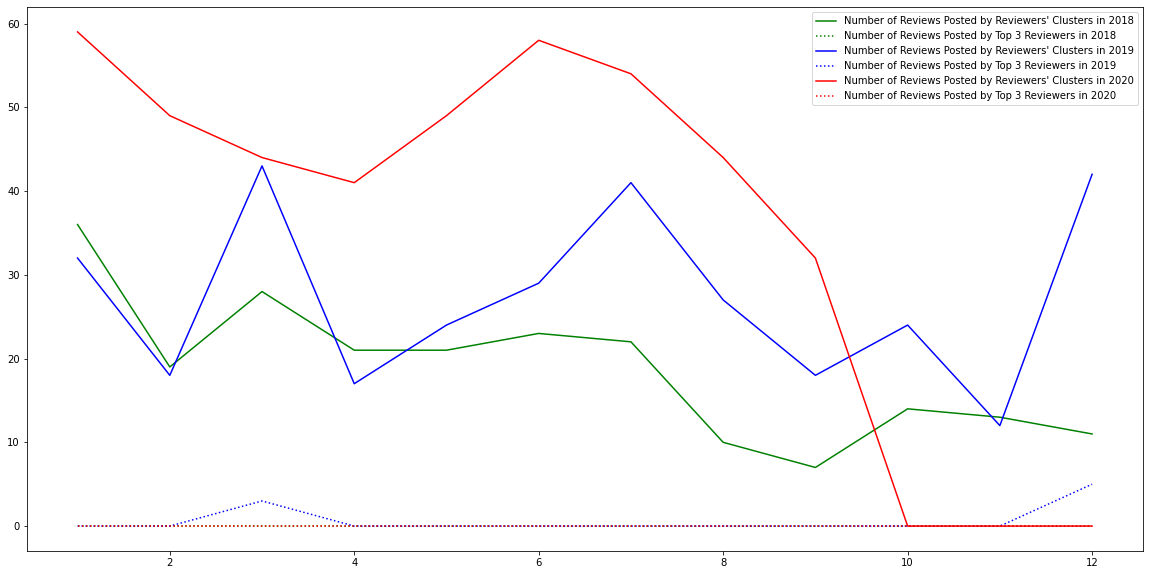

In [ ]:
df['cleaned_reviews_date_posted'] = pd.to_datetime(df['cleaned_reviews_date_posted'])
df['year'] = df['cleaned_reviews_date_posted'].dt.year
df['month'] = df['cleaned_reviews_date_posted'].dt.month
clusters_df = df[df['acc_num'].isin(unique_users)]
top3_suspicious_df = df[df['acc_num'].isin(top3_suspicious_reviewers)]

final_count_df = pd.DataFrame()

fig = plt.subplots(figsize=(20,10))

color = {0:'g',1:'b',2:'r'}
for i, year in enumerate([2018, 2019, 2020]):
    temp_clusters_df = clusters_df[clusters_df['year'] == year]
    temp_top3_suspicious_df = top3_suspicious_df[top3_suspicious_df['year'] == year]
    count_df = pd.DataFrame()
    count_df['month'] = range(1,13)
    count_clusters_df = temp_clusters_df.groupby(['month']).size().reset_index(name='count_clusters')
    count_top3_suspicious_df = temp_top3_suspicious_df.groupby(['month']).size().reset_index(name='count_reviewers')
    count_df = count_df.merge(count_clusters_df,how='left', left_on='month',right_on='month')
    count_df = count_df.merge(count_top3_suspicious_df,how='left', left_on='month',right_on='month')
    count_df['year'] = year
    count_df = count_df.fillna(0)
    final_count_df = pd.concat([final_count_df,count_df])
    plt.plot(range(1,13), count_df['count_clusters'],'-'+color[i],label="Number of Reviews Posted by Reviewers' Clusters in {}".format(year))
    plt.plot(range(1,13), count_df['count_reviewers'], ':'+color[i],label="Number of Reviews Posted by Top 3 Reviewers in {}".format(year))
plt.legend()
plt.show()